In [1]:
import pandas as pd
import os
print(os.getcwd())

IMAGE_DIR = "/mnt/imagery_data/Wernke_projects/GeoPACHA/Imagery_Machine_Learning/Analysis_Images"
VECTOR_DIR = "/mnt/imagery_data/Wernke_projects/GeoPACHA/Imagery_Machine_Learning/ChipClassification/"
#Import a scenes csv as a pandas dataframe. This is the labeled scenes from Region01
train_df = pd.read_csv('/mnt/imagery_data/Wernke_projects/GeoPACHA/Imagery_Machine_Learning/ChipClassification/ml_data_2024_10_23/scenes_train.csv')

# val_df = pd.read_csv('/workspace/data/automated_data_prep/ml_data_2024_08_23/scenes_validation.csv')


/home/zimmejr1/Documents/Software/DETR/Co-DETR_RS


In [2]:
from rastervision.core.data import (
    ClassConfig, ClassInferenceTransformer, GeoJSONVectorSource,
    Scene,GeoJSONVectorSourceConfig,ClassInferenceTransformerConfig, BufferTransformer,RasterioSource,
    RasterioCRSTransformer,ObjectDetectionLabelSource
    )
# from utility_scripts.QGIS_to_ML.geopacha_cc_label_source import GeopachaChipClassificationLabelSource
# from utility_scripts.QGIS_to_ML.geopacha_chip_classification_label_source_config import GeopachaChipClassificationLabelSourceConfig



def create_OD_scene(aoi_path,image_path,label_path=None):
    # Create Class config
    class_config = ClassConfig(
    names=['nothing', 'object'],
    colors=['lightgray', 'lightblue'],
    null_class='nothing')
    
    

    #Create crs_transformer from image
    crs_transformer = RasterioCRSTransformer.from_uri(image_path)

    # Create an extent to clip everythint to that is slightly larger than the AOI
    aoiSource = GeoJSONVectorSource(
        aoi_path,crs_transformer,vector_transformers=[BufferTransformer(geom_type='Polygon', default_buf=256)])

    #Extract AOI extent
    myextent=aoiSource.extent

    rasterSource = RasterioSource(
        image_path, #path to the image
        allow_streaming=True, # allow_streaming so we don't have to load the whole image
        bbox=myextent
        ) # Clip the image to the extent of the aoi. This means chip windows will only be created within the bounds of the aoi extent
    
    #Create the AOI
    aoiSource = GeoJSONVectorSource(
        aoi_path,rasterSource.crs_transformer,bbox=rasterSource.bbox)


    #If there are labels, import them as GeoJSONVectorSource, clipping them to the AOI extent using bbox
    
    labelSource=None
    # print(label_path)
    if not os.path.exists(label_path):
        print("No Label geojson exists")
    if label_path is not None and os.path.exists(label_path):
        #import labels as a GeoJSONVectorSource
        labelVectorSource = GeoJSONVectorSource(
            label_path, # path to the label geojson
            crs_transformer, # convert labels from geographic to pixel coordinates
            bbox=rasterSource.bbox, # clip them to the AOI extent
            vector_transformers=[
                ClassInferenceTransformer(
                    default_class_id=class_config.get_class_id('object') #use class config
                )
            ]
        )
        
        #     #Configure labels for Chip Classification
        # labelSourceConfig=GeopachaChipClassificationLabelSourceConfig(ioa_thresh=0.3, # 50% of the feature must be in the Chip for the chip to be positive. NOTE: This theshold could be changed
        #                                                     infer_cells=True, # Figure out what the cells are, we're not providing them explicitly
        #                                                     background_class_id=class_config.null_class_id, #
        #                                                     use_intersection_over_cell=True, # If true ioa_thresh would require 50% of the *chip* to contain features to be positive. That's not what we want.
        #                                                     neg_drop_probability=neg_drop_probability)


    #Convert the label vector to a lable source (format suitable for machine learning)
        try:
            labelSource=ObjectDetectionLabelSource(vector_source=labelVectorSource, #use the above label vectors
                bbox=rasterSource.bbox, #clip to aoi extent
                )
        except ValueError as e:
            pass
            # labelSource=None
            # print("There was an error. Maybe there are no labels in the AOI?")
            print(aoi_path)
            print(e)
        #Create a raster source, allow_streaming means we don't need the whole image and bbox clips the image
    
    #Finally create the scene. set the id to "platform" so we can use that information later when we create the dataset
    scene=Scene(
        id=os.path.splitext(os.path.basename(aoi_path))[0],
        raster_source=rasterSource,
        label_source=labelSource,
        aoi_polygons=aoiSource.get_geoms())
    return scene

/home/zimmejr1/anaconda3/envs/codetr/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-14 11:20:09:rastervision.pipeline.rv_config: WARNING - Root temporary directory cannot be used: /opt/data/tmp. Using root: /tmp/tmpk5fdoxz9


In [3]:
import rasterio
from rastervision.pytorch_learner import (
    ObjectDetectionSlidingWindowGeoDataset, ObjectDetectionVisualizer)
def find_patch_size(imagery_path):
    with rasterio.open(imagery_path) as image:
        target_crs = rasterio.crs.CRS.from_string('EPSG:3857')
        # print(target_crs)
        img_crs = image.crs
        # print(img_crs)
        transform = image.transform
        width=image.width
        height=image.height
        left=transform[2]
        right = left+transform[0]*width
        bottom=transform[5]+transform[4]*height
        top=transform[5]
        pixel_size = rasterio.warp.calculate_default_transform(src_crs=img_crs,dst_crs=target_crs,width=width,height=height,left=left,right=right,bottom=bottom,top=top)[0][0]
        return pixel_size



def create_OD_dataset(scene):
    pixel_size = find_patch_size(scene.raster_source.imagery_path)
    patch_ground_size = 256*.3
    #Default patch size
    msize=round(patch_ground_size/pixel_size)
    mstride=msize
    
    #Create the Dataset
    ds = ObjectDetectionSlidingWindowGeoDataset(
        scene=scene, # a scene object as created in step 1
        size=msize, # the dimension of the patch
        stride=mstride, # equal to the patch so there is no overlap and no gaps
        out_size=256, # reshape the patch to be 256x256
        # pad_direction="both",
        within_aoi=True 
    )
    return(ds)



In [4]:
train_labeled_sceneList = [create_OD_scene(os.path.join(VECTOR_DIR,*row['aoi_path'].split("\\")),os.path.join(IMAGE_DIR,*row['image_path'].split("\\")),os.path.join(VECTOR_DIR,*row['label_path'].split("\\"))) for index , row in train_df.iterrows()]
from tqdm import tqdm
train_labeled_dataset_list = [create_OD_dataset(scene) for scene in tqdm(train_labeled_sceneList,desc="Create Labeled Datasets:")]

Create Labeled Datasets:: 100%|██████████| 156/156 [00:08<00:00, 18.04it/s]


looking for boxes 0
looking for boxes 1
looking for boxes 2
looking for boxes 3
looking for boxes 4
looking for boxes 5
looking for boxes 6
looking for boxes 7
looking for boxes 8
looking for boxes 9
looking for boxes 10
looking for boxes 11
looking for boxes 12
looking for boxes 13
looking for boxes 14
looking for boxes 15
looking for boxes 16
looking for boxes 17
looking for boxes 18
looking for boxes 19
looking for boxes 20
looking for boxes 21
looking for boxes 22
looking for boxes 23
looking for boxes 24
looking for boxes 25
looking for boxes 26
looking for boxes 27
looking for boxes 28
looking for boxes 29
looking for boxes 30
looking for boxes 31
looking for boxes 32
looking for boxes 33
looking for boxes 34
looking for boxes 35
looking for boxes 36
looking for boxes 37
looking for boxes 38
looking for boxes 39
looking for boxes 40
looking for boxes 41
looking for boxes 42


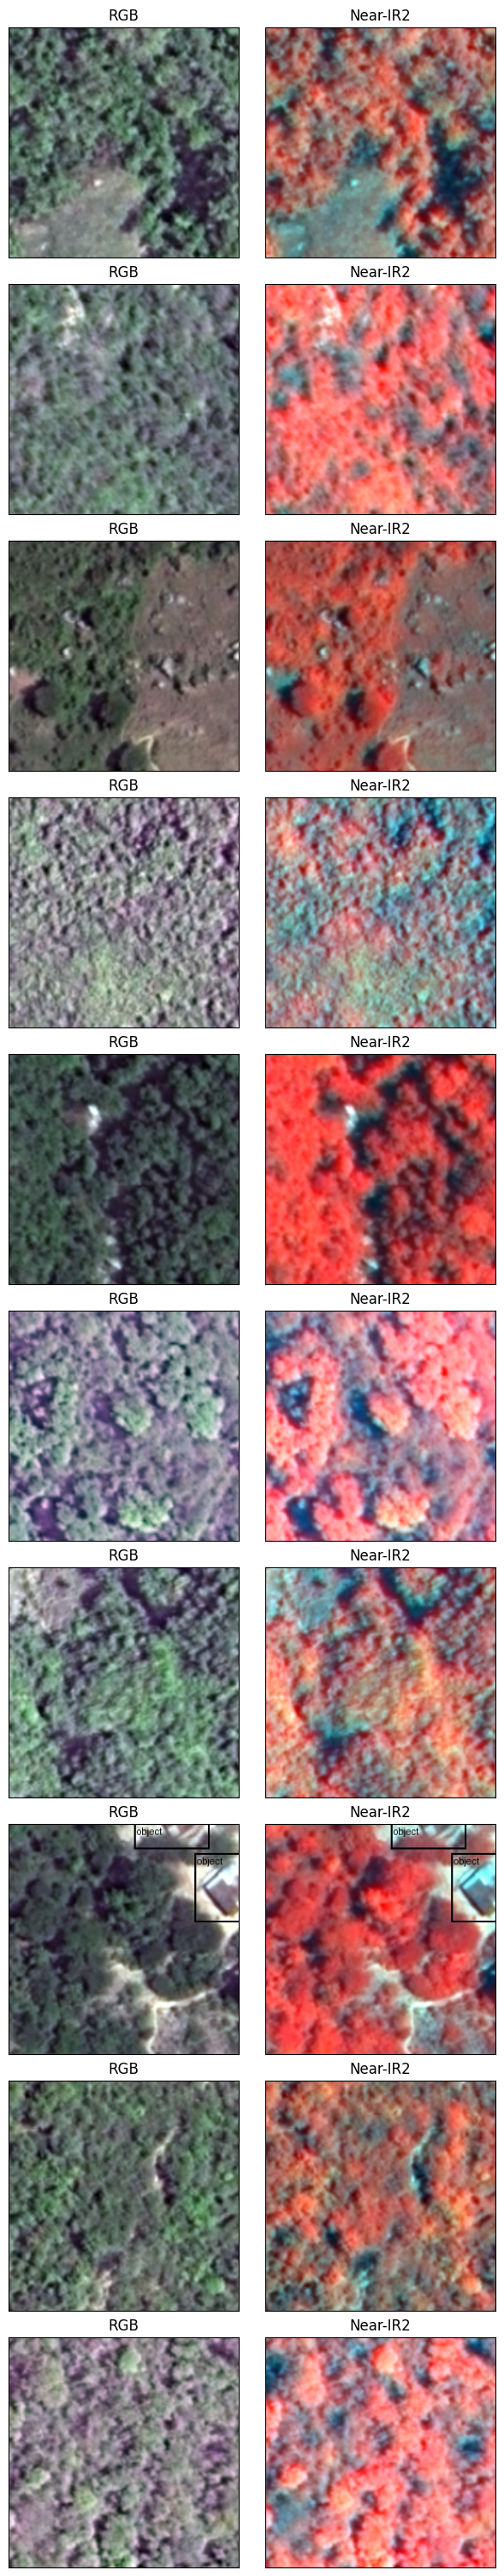

In [5]:
# Create Class config
from torch.utils.data import ConcatDataset

class_config = ClassConfig(
    names=['nothing', 'object'],
    colors=['lightgray', 'black'],
    null_class='nothing')

channel_display_groups = {'RGB': (4, 2, 1), 'Near-IR2': (7,2,1)}

vis = ObjectDetectionVisualizer(
    class_names=class_config.names, class_colors=class_config.colors,
    channel_display_groups=channel_display_groups)
count=0
while True:
    print(f"looking for boxes {count}")
    x, y = vis.get_batch(train_labeled_dataset_list[1], 10,  shuffle=True)
    # print(y)
    count+=1
    if any(len(box.boxes)>0 for box in y):
        break
    if count>500:
        break
    

# print()
vis.plot_batch(x, y, show=True)



In [6]:
# import torch
# import torchvision
# import torchvision.transforms as transforms
# import matplotlib.pyplot as plt

# # Assuming you have a DataLoader named 'dataloader'

# # Get a batch of data
# images, labels = next(iter(train_dataloader))

# # Plot the first image in the batch
# image = images[0]

# # Convert the image to numpy array
# image = image.numpy().transpose((1, 2, 0))

# # Plot the image
# plt.imshow(image)
# plt.show()
# print(labels)

In [7]:
# COCO classes
CLASSES = [
    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

coco_idx_to_label = {idx: label for idx, label in enumerate(CLASSES)}

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]


In [8]:
import matplotlib.pyplot as plt
import torch
import torchvision

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        output_tensor = []
        for t, m, s in zip(tensor, self.mean, self.std):
            output_tensor.append(t.mul(s).add(m))
            # t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return torch.stack(output_tensor, dim=0)

unnorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

def plot_results(img, labels, boxes, mask=None):
    h, w = img.shape[1:]
    if mask != None:
        # width
        if torch.where(mask[0])[0].shape[0] > 0:
            mask_w = torch.where(mask[0])[0][0]
            w = min(w, mask_w)
        if torch.where(mask[:, 0])[0].shape[0]:
            mask_h = torch.where(mask[:, 0])[0][0]
            h = min(h, mask_h)
    plt.figure(figsize=(16,10))
    unimage = unnorm(img)
    #image = (unimage*256).to(torch.uint8)
    image = unimage
    pil_img = torchvision.transforms.functional.to_pil_image(image)
    plt.imshow(pil_img)
    
    ax = plt.gca()
    colors = COLORS * 100
    for label, (xmin, ymin, xmax, ymax), c in zip(labels, boxes.tolist(), colors):
        print("rectangle coords: ", (xmin, ymin, xmax, ymax))
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{CLASSES[label]}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [9]:
from argparse import Namespace
import os
args = Namespace(config='projects/configs/co_dino_vit/co_dino_5scale_vit_large_coco.py', work_dir='my_exp1', resume_from=None,
                  auto_resume=False, no_validate=False, gpus=None, gpu_ids=None, gpu_id=0, seed=42, diff_seed=False, deterministic=False,
                    options=None, cfg_options=None, launcher='pytorch', local_rank=0, auto_scale_lr=False)

os.environ['LOCAL_RANK'] = '0'
os.environ['RANK'] = '0'
os.environ['GROUP_RANK'] = '0'
os.environ['ROLE_RANK'] = '0'
os.environ['ROLE_NAME'] = 'default'
os.environ['LOCAL_WORLD_SIZE'] = '1'
os.environ['WORLD_SIZE'] = '1'
os.environ['GROUP_WORLD_SIZE'] = '1'
os.environ['ROLE_WORLD_SIZE'] = '1'
os.environ['MASTER_ADDR'] = '127.0.0.1'
os.environ['MASTER_PORT'] = '29500'


In [10]:
import argparse
import copy
import os
import os.path as osp
import time
import warnings

import mmcv
import torch
import torch.distributed as dist
from mmcv import Config, DictAction
from mmcv.runner import get_dist_info, init_dist
from mmcv.utils import get_git_hash

from mmdet import __version__
from mmdet.apis import init_random_seed, set_random_seed, train_detector
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.utils import (collect_env, get_device, get_root_logger,
                         replace_cfg_vals, setup_multi_processes,
                         update_data_root)
from projects import *

In [11]:
cfg = Config.fromfile(args.config)
cfg = replace_cfg_vals(cfg)
update_data_root(cfg)
if args.cfg_options is not None:
    cfg.merge_from_dict(args.cfg_options)

if args.auto_scale_lr:
    if 'auto_scale_lr' in cfg and \
            'enable' in cfg.auto_scale_lr and \
            'base_batch_size' in cfg.auto_scale_lr:
        cfg.auto_scale_lr.enable = True
    else:
        warnings.warn('Can not find "auto_scale_lr" or '
                        '"auto_scale_lr.enable" or '
                        '"auto_scale_lr.base_batch_size" in your'
                        ' configuration file. Please update all the '
                        'configuration files to mmdet >= 2.24.1.')

# set multi-process settings
setup_multi_processes(cfg)

In [12]:
if cfg.get('cudnn_benchmark', False):
    torch.backends.cudnn.benchmark = True

# work_dir is determined in this priority: CLI > segment in file > filename
if args.work_dir is not None:
    # update configs according to CLI args if args.work_dir is not None
    cfg.work_dir = args.work_dir
elif cfg.get('work_dir', None) is None:
    # use config filename as default work_dir if cfg.work_dir is None
    cfg.work_dir = osp.join('./work_dirs',
                            osp.splitext(osp.basename(args.config))[0])

if args.resume_from is not None:
    cfg.resume_from = args.resume_from
cfg.auto_resume = args.auto_resume
if args.gpus is not None:
    cfg.gpu_ids = range(1)
    warnings.warn('`--gpus` is deprecated because we only support '
                    'single GPU mode in non-distributed training. '
                    'Use `gpus=1` now.')
if args.gpu_ids is not None:
    cfg.gpu_ids = args.gpu_ids[0:1]
    warnings.warn('`--gpu-ids` is deprecated, please use `--gpu-id`. '
                    'Because we only support single GPU mode in '
                    'non-distributed training. Use the first GPU '
                    'in `gpu_ids` now.')
if args.gpus is None and args.gpu_ids is None:
    cfg.gpu_ids = [args.gpu_id]

# init distributed env first, since logger depends on the dist info.
if args.launcher == 'none':
    distributed = False
else:
    distributed = True
    init_dist(args.launcher, **cfg.dist_params)
    # re-set gpu_ids with distributed training mode
    _, world_size = get_dist_info()
    cfg.gpu_ids = range(world_size)

# create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
# dump config
cfg.dump(osp.join(cfg.work_dir, osp.basename(args.config)))
# init the logger before other steps
timestamp = time.strftime('%Y%m%d_%H%M%S', time.localtime())
log_file = osp.join(cfg.work_dir, f'{timestamp}.log')
logger = get_root_logger(log_file=log_file, log_level=cfg.log_level)

# init the meta dict to record some important information such as
# environment info and seed, which will be logged
meta = dict()
# log env info
env_info_dict = collect_env()
env_info = '\n'.join([(f'{k}: {v}') for k, v in env_info_dict.items()])
dash_line = '-' * 60 + '\n'
logger.info('Environment info:\n' + dash_line + env_info + '\n' +
            dash_line)
meta['env_info'] = env_info
meta['config'] = cfg.pretty_text
# log some basic info
logger.info(f'Distributed training: {distributed}')
logger.info(f'Config:\n{cfg.pretty_text}')

cfg.device = get_device()
# set random seeds
seed = init_random_seed(args.seed, device=cfg.device)
seed = seed + dist.get_rank() if args.diff_seed else seed
logger.info(f'Set random seed to {seed}, '
            f'deterministic: {args.deterministic}')
set_random_seed(seed, deterministic=args.deterministic)
cfg.seed = seed
meta['seed'] = seed
meta['exp_name'] = osp.basename(args.config)

2024-11-14 11:24:02,279 - mmdet - INFO - Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.10.15 (main, Oct  3 2024, 07:27:34) [GCC 11.2.0]
CUDA available: True
GPU 0: NVIDIA GeForce RTX 4070 Ti
CUDA_HOME: /home/zimmejr1/anaconda3/envs/codetr
NVCC: Cuda compilation tools, release 11.8, V11.8.89
GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
PyTorch: 1.11.0
PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) oneAPI Math Kernel Library Version 2023.1-Product Build 20230303 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.5.2 (Git Hash a9302535553c73243c632ad3c4c80beec3d19a1e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.3
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-

In [13]:
model = build_detector(
    cfg.model,
    train_cfg=cfg.get('train_cfg'),
    test_cfg=cfg.get('test_cfg'))
model.init_weights()

======== shape of rope freq torch.Size([576, 64]) ========
======== shape of rope freq torch.Size([9216, 64]) ========


2024-11-14 11:24:09,352 - mmdet - INFO - initialize RPNHead with init_cfg {'type': 'Normal', 'layer': 'Conv2d', 'std': 0.01}
2024-11-14 11:24:09,419 - mmdet - INFO - initialize ConvFCBBoxHead with init_cfg [{'type': 'Normal', 'std': 0.01, 'override': {'name': 'fc_cls'}}, {'type': 'Normal', 'std': 0.001, 'override': {'name': 'fc_reg'}}, {'type': 'Xavier', 'distribution': 'uniform', 'override': [{'name': 'shared_fcs'}, {'name': 'cls_fcs'}, {'name': 'reg_fcs'}]}]
2024-11-14 11:24:09,470 - mmdet - INFO - initialize CoATSSHead with init_cfg {'type': 'Normal', 'layer': 'Conv2d', 'std': 0.01, 'override': {'type': 'Normal', 'name': 'atss_cls', 'std': 0.01, 'bias_prob': 0.01}}
2024-11-14 11:24:09,512 - mmdet - WARNING - No pre-trained weights for ViT, training start from scratch
2024-11-14 11:24:10,445 - mmdet - INFO - initialize SFP with init_cfg {'type': 'Xavier', 'layer': 'Conv2d', 'distribution': 'uniform'}


In [14]:
datasets = [build_dataset(cfg.data.train)]
datasets

loading annotations into memory...
Done (t=7.56s)
creating index...
index created!


[
 CocoDataset Train dataset with number of images 118287, and instance counts: 
 +---------------------+--------+-----------------+-------+--------------------+-------+--------------------+-------+-------------------+-------+
 | category            | count  | category        | count | category           | count | category           | count | category          | count |
 +---------------------+--------+-----------------+-------+--------------------+-------+--------------------+-------+-------------------+-------+
 | 0 [person]          | 257249 | 1 [bicycle]     | 7056  | 2 [car]            | 43532 | 3 [motorcycle]     | 8654  | 4 [airplane]      | 5129  |
 | 5 [bus]             | 6061   | 6 [train]       | 4570  | 7 [truck]          | 9970  | 8 [boat]           | 10575 | 9 [traffic light] | 12841 |
 | 10 [fire hydrant]   | 1865   | 11 [stop sign]  | 1983  | 12 [parking meter] | 1283  | 13 [bench]         | 9820  | 14 [bird]         | 10537 |
 | 15 [cat]            | 4766   | 16 [dog] 

In [15]:
len(datasets[0])

118287

rectangle coords:  (434.1047058105469, 376.7937927246094, 724.0148315429688, 927.3297729492188)
rectangle coords:  (377.02496337890625, 57.123558044433594, 773.7468872070312, 832.3387451171875)
rectangle coords:  (341.4468688964844, 445.4915771484375, 434.0531005859375, 569.482666015625)
rectangle coords:  (318.0374755859375, 472.5324401855469, 397.00543212890625, 562.703125)


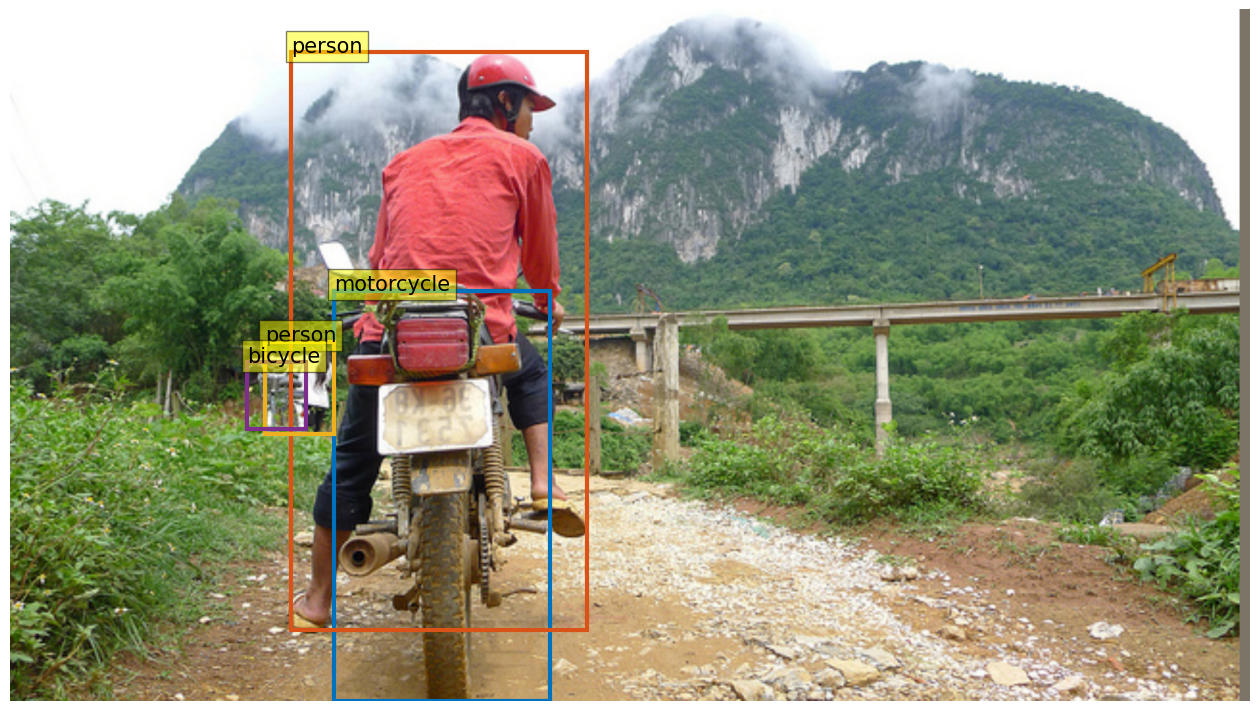

In [16]:
sample = datasets[0][0]
plot_results(sample["img"].data, sample["gt_labels"].data, sample["gt_bboxes"].data)

In [17]:
from mmdet.utils import (build_ddp, build_dp, compat_cfg,
                         find_latest_checkpoint, get_root_logger)

from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)

dataset = datasets
cfg = compat_cfg(cfg)
logger = get_root_logger(log_level=cfg.log_level)

# prepare data loaders
dataset = dataset if isinstance(dataset, (list, tuple)) else [dataset]

runner_type = 'EpochBasedRunner' if 'runner' not in cfg else cfg.runner[
    'type']

train_dataloader_default_args = dict(
    samples_per_gpu=1,
    workers_per_gpu=1,
    # `num_gpus` will be ignored if distributed
    num_gpus=len(cfg.gpu_ids),
    dist=distributed,
    seed=49,
    runner_type=runner_type,
    persistent_workers=False)

train_loader_cfg = {
    **train_dataloader_default_args,
    **cfg.data.get('train_dataloader', {})
}

data_loaders = [build_dataloader(ds, **train_loader_cfg) for ds in dataset]

306724

In [26]:
def coco_box(label):
    label_dict={}
    label_dict['boxes']=label.convert_boxes('xywh')
    label_dict['labels']=label.get_field('class_ids')
    return label_dict
   

def collate_fn(data):
    imgs = [d[0][[4,2,1],:,:] for d in data]
    x = torch.stack(imgs)
    y: targets= [coco_box(d[1]) for d in data]
    return x, y

from torch.utils.data import DataLoader
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)


runner_type = 'EpochBasedRunner' if 'runner' not in cfg else cfg.runner[
    'type']
             

train_dataloader_default_args = dict(
    samples_per_gpu=1,
    workers_per_gpu=1,
    # `num_gpus` will be ignored if distributed
    num_gpus=len(cfg.gpu_ids),
    dist=distributed,
    seed=49,
    runner_type=runner_type,
    persistent_workers=False)
                   
# from rastervision.pytorch_learner.object_detection_utils import (collate_fn)
train_loader_cfg = {
    **train_dataloader_default_args,
    **cfg.data.get('train_dataloader', {})
}


train_labeled_dataset = ConcatDataset(train_labeled_dataset_list)
train_labeled_dataset.flag=[1 for _ in range(len(train_labeled_dataset))]

data_loaders = [build_dataloader(train_labeled_dataset, **train_loader_cfg,collate_fn=collate_fn) for ds in train_labeled_dataset]


TypeError: torch.utils.data.dataloader.DataLoader() got multiple values for keyword argument 'collate_fn'

In [ ]:
for samples in data_loaders[0]:
    break
samples

{'img_metas': DataContainer([[{'filename': 'data/coco/train2017/000000125983.jpg', 'ori_filename': '000000125983.jpg', 'ori_shape': (640, 458, 3), 'img_shape': (1207, 864, 3), 'pad_shape': (1216, 864, 3), 'scale_factor': array([1.8864629, 1.8859375, 1.8864629, 1.8859375], dtype=float32), 'flip': True, 'flip_direction': 'horizontal', 'img_norm_cfg': {'mean': array([123.675, 116.28 , 103.53 ], dtype=float32), 'std': array([58.395, 57.12 , 57.375], dtype=float32), 'to_rgb': True}}]]),
 'img': DataContainer([tensor([[[[0.8618, 0.8618, 0.8618,  ..., 1.4098, 1.3927, 1.3927],
           [0.8618, 0.8618, 0.8618,  ..., 1.4098, 1.3927, 1.3927],
           [0.8618, 0.8618, 0.8618,  ..., 1.3927, 1.3927, 1.3927],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
          [[0.4678, 0.4678, 0.4678,  ..., 0.9755, 0.9755, 0.9755],
   

In [ ]:
# put model on gpus
if distributed:
    find_unused_parameters = cfg.get('find_unused_parameters', False)
    # Sets the `find_unused_parameters` parameter in
    # torch.nn.parallel.DistributedDataParallel
    model = build_ddp(
        model,
        cfg.device,
        device_ids=[int(os.environ['LOCAL_RANK'])],
        broadcast_buffers=False,
        find_unused_parameters=find_unused_parameters)
else:
    model = build_dp(model, cfg.device, device_ids=cfg.gpu_ids)

In [ ]:
samples["gt_labels"].data[0][0]

tensor([ 0,  0,  0,  0,  0,  0,  0, 28, 28,  0,  0,  0, 74,  0,  0,  0])

rectangle coords:  (221.1688995361328, 27.27065658569336, 542.58447265625, 1107.346923828125)
rectangle coords:  (711.8756103515625, 122.661376953125, 859.8875732421875, 661.3983154296875)
rectangle coords:  (480.9159851074219, 316.498046875, 619.3257446289062, 577.1345825195312)
rectangle coords:  (118.28125, 334.376708984375, 228.0167694091797, 572.8157958984375)
rectangle coords:  (1.1130062341690063, 342.0147705078125, 75.91124725341797, 546.8841552734375)
rectangle coords:  (449.1668395996094, 263.93695068359375, 524.738525390625, 410.34228515625)
rectangle coords:  (654.5271606445312, 176.2220001220703, 755.49072265625, 280.4011535644531)
rectangle coords:  (514.3252563476562, 666.8109130859375, 838.8157348632812, 1207.0)
rectangle coords:  (24.806976318359375, 507.7320861816406, 125.90251922607422, 654.1751098632812)
rectangle coords:  (641.623779296875, 339.41217041015625, 699.2174682617188, 410.02166748046875)
rectangle coords:  (40.12504577636719, 283.7581481933594, 115.48926

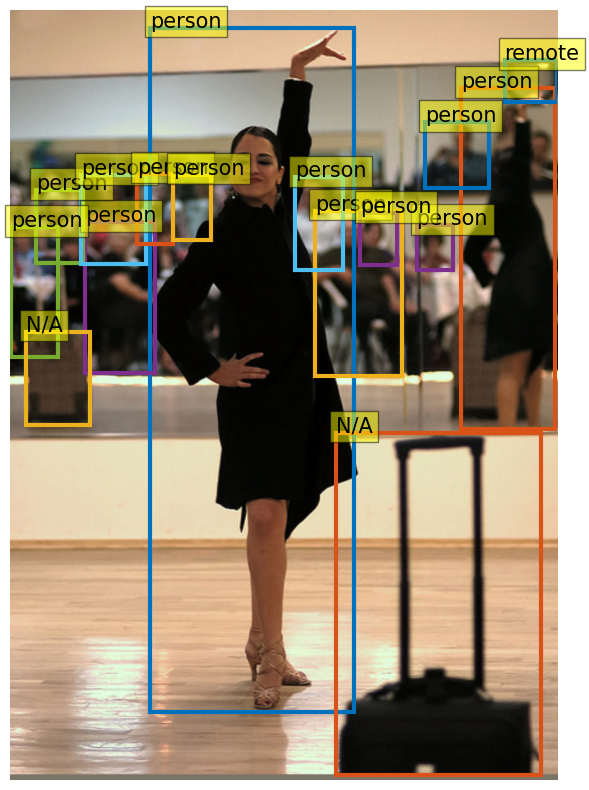

In [ ]:
plot_results(samples["img"].data[0][0], samples["gt_labels"].data[0][0], samples["gt_bboxes"].data[0][0])

In [ ]:
samples

{'img_metas': DataContainer([[{'filename': 'data/coco/train2017/000000125983.jpg', 'ori_filename': '000000125983.jpg', 'ori_shape': (640, 458, 3), 'img_shape': (1207, 864, 3), 'pad_shape': (1216, 864, 3), 'scale_factor': array([1.8864629, 1.8859375, 1.8864629, 1.8859375], dtype=float32), 'flip': True, 'flip_direction': 'horizontal', 'img_norm_cfg': {'mean': array([123.675, 116.28 , 103.53 ], dtype=float32), 'std': array([58.395, 57.12 , 57.375], dtype=float32), 'to_rgb': True}, 'batch_input_shape': (1216, 864)}]]),
 'img': DataContainer([tensor([[[[0.8618, 0.8618, 0.8618,  ..., 1.4098, 1.3927, 1.3927],
           [0.8618, 0.8618, 0.8618,  ..., 1.4098, 1.3927, 1.3927],
           [0.8618, 0.8618, 0.8618,  ..., 1.3927, 1.3927, 1.3927],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
          [[0.4678, 0.4678, 0.4678, 

In [ ]:
model(**samples)

/home/zimmejr1/Documents/Software/DETR/Co-DETR/mmdet/models/utils/positional_encoding.py:81: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature**(2 * (dim_t // 2) / self.num_feats)
/home/zimmejr1/anaconda3/envs/codetr/lib/python3.10/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/zimmejr1/Documents/Software/DETR/Co-DETR/projects/models/transformer.py:476: 

{'enc_loss_cls': tensor([0.2391], device='cuda:0', grad_fn=<MulBackward0>),
 'enc_loss_bbox': tensor(1.2909, device='cuda:0', grad_fn=<MulBackward0>),
 'enc_loss_iou': tensor(2.0080, device='cuda:0', grad_fn=<MulBackward0>),
 'loss_cls': tensor([0.2214], device='cuda:0', grad_fn=<MulBackward0>),
 'loss_bbox': tensor(1.2737, device='cuda:0', grad_fn=<MulBackward0>),
 'loss_iou': tensor(2.0076, device='cuda:0', grad_fn=<MulBackward0>),
 'd0.loss_cls': tensor([0.1689], device='cuda:0', grad_fn=<MulBackward0>),
 'd0.loss_bbox': tensor(1.3000, device='cuda:0', grad_fn=<MulBackward0>),
 'd0.loss_iou': tensor(2.0408, device='cuda:0', grad_fn=<MulBackward0>),
 'd1.loss_cls': tensor([0.1944], device='cuda:0', grad_fn=<MulBackward0>),
 'd1.loss_bbox': tensor(1.2764, device='cuda:0', grad_fn=<MulBackward0>),
 'd1.loss_iou': tensor(2.0160, device='cuda:0', grad_fn=<MulBackward0>),
 'd2.loss_cls': tensor([0.2031], device='cuda:0', grad_fn=<MulBackward0>),
 'd2.loss_bbox': tensor(1.2737, device='cud

In [ ]:
model

MMDistributedDataParallel(
  (module): CoDETR(
    (backbone): ViT(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
      )
      (rope_win): VisionRotaryEmbeddingFast()
      (rope_glb): None
      (blocks): ModuleList(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (q_proj): Linear(in_features=1024, out_features=1024, bias=False)
            (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=False)
            (rope): VisionRotaryEmbeddingFast()
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): SwiGLU(
            (w1): Linear(in_features=1024, out_features=2730, bias=True)
            (w2): Linear(

In [ ]:
 for name, l in model.named_modules():
    if name == "module.backbone":
        print(l)

ViT(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
  )
  (rope_win): VisionRotaryEmbeddingFast()
  (rope_glb): None
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (q_proj): Linear(in_features=1024, out_features=1024, bias=False)
        (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
        (v_proj): Linear(in_features=1024, out_features=1024, bias=False)
        (rope): VisionRotaryEmbeddingFast()
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): SwiGLU(
        (w1): Linear(in_features=1024, out_features=2730, bias=True)
        (w2): Linear(in_features=1024, out_features=2730, bias=True)
        (act): SiLU()
        (ffn_ln): LayerNorm((2730,), eps=1e-06, elementwise_affine=True)


In [ ]:
if len(cfg.workflow) == 2:
    assert 'val' in [mode for (mode, _) in cfg.workflow]
    val_dataset = copy.deepcopy(cfg.data.val)
    val_dataset.pipeline = cfg.data.train.get(
        'pipeline', cfg.data.train.dataset.get('pipeline'))
    datasets.append(build_dataset(val_dataset))
if cfg.checkpoint_config is not None:
    # save mmdet version, config file content and class names in
    # checkpoints as meta data
    cfg.checkpoint_config.meta = dict(
        mmdet_version=__version__ + get_git_hash()[:7],
        CLASSES=datasets[0].CLASSES)
# add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

In [18]:
train_detector(
    model,
    datasets,
    cfg,
    distributed=distributed,
    validate=(not args.no_validate),
    timestamp=timestamp,
    meta=meta)

In [ ]:
from mmengine.runner import Runner
runner = Runner(
    model=model,
    work_dir = './work_dir',
    train_dataloader = 
)

In [ ]:
torch.cuda.is_available()

True